In [1]:
import numpy as np
import matplotlib.pyplot as plt
SEED = 8

In [11]:
class SingleLayerSNN:
    
    def __init__(self, inputs, weights, outputs, Cm=4, Rm=5, V_thresh=30, V_rest=-65, V_spike=80, dT=0.02):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        inputs (double[][][]): A 3d numpy array of the input voltages per timestep
                        weights (double[]): A numpy array of initial weights
                        outputs (double[][][]): A 3d numpy array of the output voltages per timestep used for teaching neuron
                Returns:
                        None
        """

        self.inputs = inputs
        self.weights = weights
        self.outputs = outputs
        self.Cm = Cm
        self.Rm = Rm
        self.V_thresh = V_thresh
        self.V_rest = V_rest
        self.V_spike = V_spike
        self.dT = dT
        self._LIF_spikes = 0                    
        
    def LIF(self, I):
        """
        Runs a LIF simulation on neuron and returns outputted voltage

                Parameters:
                        I (double[]): A numpy array of input voltages in mV

                Returns:
                        V (double[]): A numpy array of the output voltages in mV
        """
        total_time = (I.size) * self.dT

        # an array of time
        time = np.arange(0, total_time, self.dT)

        # default voltage list set to resting volatage of -65mV
        V = (self.V_rest) * np.ones(len(time))

        did_spike = False

        # function member variable to track spikes
        self._LIF_spikes = 0

        for t in range(len(time)):
            # using "I - V(t)/Rm = Cm * dV/dT"
            dV = (I[t] - (V[t - 1] - self.V_rest) / self.Rm) / self.Cm

            # reset membrane potential if neuron spiked last tick
            if did_spike:
                V[t] = self.V_rest + dV * self.dT
            else:
                V[t] = V[t - 1] + dV * self.dT

            # check if membrane voltage exceeded threshold (spike)
            if V[t] > self.V_thresh:
                did_spike = True
                # set the last step to spike value
                V[t] = self.V_spike
                self._LIF_spikes += 1
            else:
                did_spike = False

        return V
    
    def voltage_to_output(self, V_input):
        V_output = np.array([])
        for v in V_input:
            V_output = np.append(V_output, 0 if v < self.V_spike else v)
        return V_output
    
    # returns the voltages of input and output neurons
    def feed_forward(self, inputs, outputs):
        input_voltages = []
        output_inputs = []
        for input_set, weight_set in zip(inputs, weights.T):
            """
            inputs: [[80, 80, 80, 80, 80], [80, 80, 80, 80, 80]]
            weights: [[.5], [.5]]
            """
            for inp in input_set:
                input_voltages.append(self.LIF(inp))
                            
            weighted_sum = np.zeros(len(input_set[0]))
            
            for V_input, weight in zip(input_voltages, weight_set): # [80, 80, 80, 80, 80]
                # a neuron only outputs if it spikes
                input_output = self.voltage_to_output(V_input)
                
                weighted = input_output * weight
                weighted_sum = np.add(weighted_sum, weighted)
            
            output_inputs.append(weighted_sum)
            
        print('input_voltages:')
        print(np.array(input_voltages))
        print('output_inputs:')
        print(np.array(output_inputs))
        
        # run LIF on output neurons
        output_voltages = []
        for inp in output_inputs:
            output_voltages.append(self.LIF(inp))
            
        print('output_voltages:')
        print(np.array(output_voltages))
        
        return np.array(input_voltages), np.array(output_voltages)
                
                    
    def train(self, epochs=100):
        for epoch in range(epochs):
            input_voltages, output_voltages = self.feed_forward(self.inputs, self.outputs)
            
            for input_voltage in input_voltages:
                plt.plot(input_voltage, alpha=0.5)
                
            for output_voltage in output_voltages:
                plt.plot(output_voltage, alpha=0.7)
                
            plt.show
            


input_voltages:
[[-40.         -15.125        9.625625    80.         -40.725
  -15.846375     8.90785688  80.         -40.725      -15.846375
    8.90785688  80.         -40.725      -15.846375     8.90785688
   80.         -40.725      -15.846375     8.90785688  80.
  -40.725      -15.846375     8.90785688  80.         -40.725
  -15.846375     8.90785688  80.         -40.725      -15.846375
    8.90785688  80.         -40.725      -15.846375     8.90785688
   80.         -40.725      -15.846375     8.90785688  80.
  -40.725      -15.846375     8.90785688  80.         -40.725
  -15.846375     8.90785688  80.         -40.725      -15.846375
    8.90785688  80.         -40.725      -15.846375     8.90785688
   80.         -40.725      -15.846375     8.90785688  80.
  -40.725      -15.846375     8.90785688  80.         -40.725
  -15.846375     8.90785688  80.         -40.725      -15.846375
    8.90785688  80.         -40.725      -15.846375     8.90785688
   80.         -40.725      -15

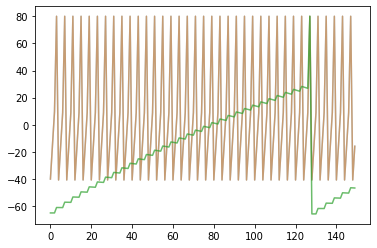

In [15]:
units_of_time = 150
inputs = np.array([
    [[1000] * units_of_time, [1000] * units_of_time],
#     [[80] * units_of_time, [0] * units_of_time],
#     [[0] * units_of_time, [80] * units_of_time],
#     [[0] * units_of_time, [0] * units_of_time],
])

weights = np.array([
    [1], 
    [1],
])

outputs = np.array([
    [[80] * units_of_time],
#     [[0] * units_of_time],
#     [[0] * units_of_time],
#     [[0] * units_of_time],
])

and_network = SingleLayerSNN(inputs=inputs, weights=weights, outputs=outputs, dT=0.1)

and_network.train(1)
